# Data assimilation in neXtSIM-DG with NEDAS
Authors: Yue (Michael) Ying (NERSC), Ali Aydogdu (CMCC), Yumeng Chen (U. Reading)

Data assimilation combines information from model forecasts and observations to obtain the best estimate of model state and parameters.

In this tutorial, we show an Observing System Simulation Experiment (OSSE) where synthetic observations are simulated from a truth run.

The assimilation of synthetic observations reduce errors in the model states, which are diagnosed against the truth.


## Environment and configuration

In [1]:
import os
import sys

import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean
from NEDAS.utils.graphics import add_colorbar, adjust_ax_size

##for display of plots with sliders
import ipywidgets as widgets
from IPython.display import display, HTML, Image, clear_output

from NEDAS.config import Config
from NEDAS.schemes import get_analysis_scheme


Check how many CPUs are available on your system, you can then set the number of processors `nproc` and ensemble size `nens` accordingly


In [2]:
os.cpu_count()

8

In [3]:
# Configuration
config_file = "/home/nextsim-workshop/notebooks-nextsim-workshop2025/assimilation/config.yml"

c = Config(config_file=config_file,
           nproc=6, ## number of processors; set according to your cpu count
           nens=6,  ## ensemble size
           debug=False,
          )

In [8]:
# number of cycles
ncycle = int((c.time_end - c.time_start) / (c.cycle_period*timedelta(hours=1)))


In [10]:
# model class for nextsim.dg
model = c.models['nextsim.dg']

model

In [6]:
# Analysis scheme: offline filter in this case
scheme = get_analysis_scheme(c)

scheme

To run the analysis, you can run `scheme(c)`

or in bash command line:

`python -m NEDAS -c config.yml`

In [ ]:
#you can just run this to perform the experiment defined in config.yml
scheme(c)

File structure in `c.work_dir`:

- `truth`: where the truth runs are located, this path is configurable in `model.truth_dir`.
- `icbc`: where the initial and boundary condition files are located.
- `large_ens`: a separately prepared ensemble can be used to start the cycling, configurable in `model.ens_init_dir`.
- `cycle`: runtime output for cycling DA experiment.

```
cycle
├── 201001010000 (datetime in %Y%m%d%H%M format)
│   └── nextsim.dg  (ensemble forecast runtime output)
│        ├── ens_01
│        │     ├── 25km_NH.ERA5.nc
│        │     ├── 25km_NH.TOPAZ4.nc
│        │     ├── restart2010-01-01T00:00:00Z.nc
│        │     └── restart2010-01-01T06:00:00Z.nc
│        ├── ens_02
│        └── ...
├── 201001010600
├── 201001011200
├── 201001011800
│   └── nextsim.dg
│        ├── ens_01
│        │     ├── 25km_NH.ERA5.nc    (slice of the atmos forcing, perturbed)
│        │     ├── 25km_NH.TOPAZ4.nc  (slice of the ocean forcing, perturbed)
│        │     ├── restart2010-01-01T18:00:00Z.nc
│        │     └── restart2010-01-02T00:00:00Z.nc (forecast to next cycle; the "prior")
│        ├── ens_02
│        └── ...
├── 201001020000 (first analysis cycle)
│   ├── analysis (filter step runtime output)
│   │    ├── prior_state.bin
│   │    ├── post_state.bin
│   │    └── obs_seq*.npy
│   └── nextsim.dg (ensemble forecast runtime output)
│        ├── ens_01
│        │     ├── 25km_NH.ERA5.nc
│        │     ├── 25km_NH.TOPAZ4.nc
│        │     ├── restart2010-01-02T00:00:00Z.nc (analysis state; the "posterior")
│        │     └── restart2010-01-02T06:00:00Z.nc (forecast to next cycle)
│        ├── ens_02
│        └── ...
├── ...
└── 201001031800 (last cycle)
```

## Truth run

You can skip this section, the truth run is already in the data you downloaded

In [17]:
run_dir = os.path.join(model.truth_dir, 'run', 'ens_01')
os.system("mkdir -p "+run_dir)

icbc_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/icbc"
init_file = os.path.join(icbc_dir, f"restart{c.time_start:%Y-%m-%dT%H:%M:%SZ}.nc")
atmos_forcing_file = os.path.join(icbc_dir, "25km_NH.ERA5.nc")
ocean_forcing_file = os.path.join(icbc_dir, "25km_NH.TOPAZ4.nc")
for file in [init_file, atmos_forcing_file, ocean_forcing_file]:
    os.system(f"ln -fs {file} {run_dir}/.")

c.time = c.time_start
while c.time < c.time_end:
    file = f"restart{c.time:%Y-%m-%dT%H:%M:%SZ}.bin"
    next_file = f"restart{c.next_time:%Y-%m-%dT%H:%M:%SZ}.bin"
    print(f"Running the model from condition {file} to reach {next_file}")

    model.run(path=os.path.join(model.truth_dir, 'run'),
              member=0,
              time=c.time,
              forecast_period=c.cycle_period,
              time_start=c.time_start,
              time_end=c.time_end,
              debug=c.debug,
              **c.job_submit)

    c.time = c.next_time

# clean up
os.system(f"mv {run_dir}/restart*.nc {model.truth_dir}/.")
tmp_dir = os.path.join(model.truth_dir, 'run')
os.system(f"rm -rf {tmp_dir}")
print("done.")

Running the model from condition restart2010-01-01T00:00:00Z.bin to reach restart2010-01-01T06:00:00Z.bin
Running the model from condition restart2010-01-01T06:00:00Z.bin to reach restart2010-01-01T12:00:00Z.bin
Running the model from condition restart2010-01-01T12:00:00Z.bin to reach restart2010-01-01T18:00:00Z.bin
Running the model from condition restart2010-01-01T18:00:00Z.bin to reach restart2010-01-02T00:00:00Z.bin
Running the model from condition restart2010-01-02T00:00:00Z.bin to reach restart2010-01-02T06:00:00Z.bin
Running the model from condition restart2010-01-02T06:00:00Z.bin to reach restart2010-01-02T12:00:00Z.bin
Running the model from condition restart2010-01-02T12:00:00Z.bin to reach restart2010-01-02T18:00:00Z.bin
Running the model from condition restart2010-01-02T18:00:00Z.bin to reach restart2010-01-03T00:00:00Z.bin
Running the model from condition restart2010-01-03T00:00:00Z.bin to reach restart2010-01-03T06:00:00Z.bin
Running the model from condition restart2010-0

In [8]:
# list of variables in nextsim.dg model
model.variables.keys()

dict_keys(['seaice_conc_dg', 'seaice_thick_dg', 'seaice_damage', 'snow_thick', 'seaice_temp_k', 'seaice_velocity', 'seaice_conc', 'seaice_thick', 'atmos_surf_velocity', 'atmos_surf_press', 'atmos_surf_temp', 'atmos_surf_dewpoint', 'atmos_down_shortwave', 'atmos_down_longwave', 'ocean_surf_velocity', 'ocean_surf_temp', 'ocean_surf_salinity', 'ocean_mixl_depth'])

In [12]:
# pick a variable to plot, sea ice concentration for example.
vname = 'seaice_conc'
vmin = 0
vmax = 1
cmap = cmocean.cm.ice


In [ ]:
vname = 'seaice_thick'
vmin = 0
vmax = 3
cmap = 'viridis'

In [12]:
for n in range(ncycle):
    time = c.time_start + n * c.cycle_period * timedelta(hours=1)
    fld = model.read_var(path=model.truth_dir, time=time, name=vname)
    if n==0:
        model.grid.mask = np.isnan(fld)
    else:
        fld[model.grid.mask] = np.nan

    fig, ax = plt.subplots(1,1,figsize=(6,4.5))
    model.grid.plot_field(ax, fld, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax, cmap, vmin, vmax)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"{vname} {time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()


In [13]:
# view figures
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=ncycle-1,
    step=1,
    description='Cycle:',
    continuous_update=False
)
output = widgets.Output()

def update_plot(n):
    with output:
        clear_output(wait=True)
        time = c.time_start + n * c.cycle_period * timedelta(hours=1)
        display(Image(filename=os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, n=slider)
display(output)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cycle:', max=11), Output()), _d…

Output()

## Ensemble generation

Check nextsim-config.yml perturb section for parameters

You can try to change:

- `amp` (standard deviation of perturbations)
- `hcorr` (horizontal correlation length, in meters)
- `tcorr` (temporal correlation length, in hours)

By default the atmospheric forcing (wind) is perturbed using Evensen 1994 approach to generate ensemble members

In [14]:
# generate ensemble by perturbed runs, test the effect of changing parameters
def generate_init_ens():
    c.time = c.time_start
    os.system("mkdir -p "+c.cycle_dir(c.time))
    # preprocessing, linking files and perturbing boundary forcing files
    scheme.run_step(c, 'preprocess', mpi=False)
    # run ensemble forecast step
    scheme.run_step(c, 'ensemble_forecast', mpi=False)

generate_init_ens()


RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/icbc
..................................................| 100% done.
timer: preprocess took 6.142290115356445 seconds

RUNNING ensemble_forecast step
Running nextsim.dg ensemble forecast:
..................................................| 100% done.
timer: ensemble_forecast took 8.94710659980774 seconds


In [41]:
vname = 'seaice_conc'
vmin = 0
vmax = 1
cmap = cmocean.cm.ice

In [29]:
vname = 'seaice_thick'
vmin = 0
vmax = 3
cmap = 'viridis'

In [30]:
# plot ensemble state for visualization
c.time = c.time_start
path = c.forecast_dir(c.time, 'nextsim.dg')

for m in range(c.nens):
    fld = model.read_var(path=path, time=c.next_time, name=vname, member=m)
    fld[model.grid.mask] = np.nan

    fig, ax = plt.subplots(1,1,figsize=(6,4.5))
    model.grid.plot_field(ax, fld, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax, cmap, vmin, vmax)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"member {m+1:02} {vname} {c.next_time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(path, f"mem{m+1:02}_{vname}_{c.next_time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()

In [45]:
c.time = c.time_start

slider = widgets.IntSlider(
    value=0,
    min=1,
    max=c.nens,
    step=1,
    description='Member:',
    continuous_update=False
)
output = widgets.Output()

def update_plot(m):
    with output:
        clear_output(wait=True)
        path = c.forecast_dir(c.time, 'nextsim.dg')
        time = c.next_time
        display(Image(filename=os.path.join(path, f"mem{m:02}_{vname}_{c.next_time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, m=slider)
display(output)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Member:', max=6, min=1), Output…

Output()

In [ ]:
# run free ensemble (NoDA) for the entire time period
def run_free_ens():
    c.time = c.time_start
    
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)
        os.system("mkdir -p "+c.cycle_dir(c.time))

        # preprocessing, linking files and perturbing boundary forcing files
        scheme.run_step(c, 'preprocess', mpi=False)

        # run ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_free_ens()


## Diagnose func for error and ensemble spread

In [19]:
# error and ensemble spread time series
def get_error_stats(path, time, vname):
    truth = model.read_var(path=model.truth_dir, time=time, name=vname)

    # ensemble mean state
    mean = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        mean += model.read_var(path=path, time=time, name=vname, member=m)
    mean /= c.nens

    # ensemble spread
    vari = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        mem = model.read_var(path=path, time=time, name=vname, member=m)
        vari += (mem - mean)**2
    vari /= c.nens-1

    rmse = np.sqrt(np.nanmean((mean - truth)**2))
    sprd = np.sqrt(np.nanmean(vari))
    return rmse, sprd

def get_error_ts(cycle_dir, vname):
    ts = []
    rmse_ts = []
    sprd_ts = []
    dt = c.cycle_period * timedelta(hours=1)
    for n in range(ncycle):
        time = c.time_start + n * dt
        path = os.path.join(cycle_dir, f'{time:%Y%m%d%H%M}', 'nextsim.dg')

        rmse, sprd = get_error_stats(path, time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(time)
        
        next_time = c.time_start + (n+1) * dt
        rmse, sprd = get_error_stats(path, next_time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(next_time)
    return ts, rmse_ts, sprd_ts

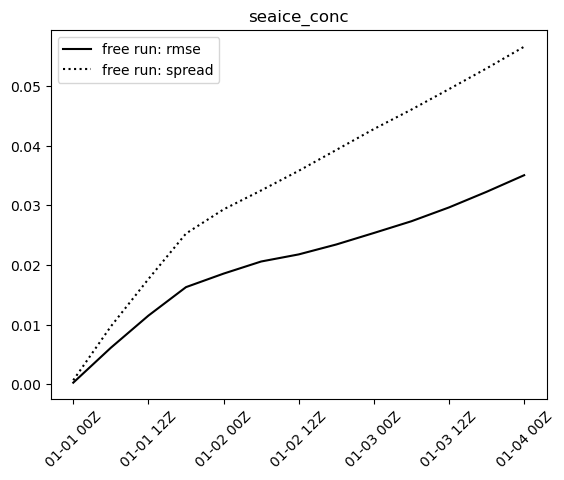

In [20]:
vname = 'seaice_conc'

cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle-free"
ts, rmse_ts_free, sprd_ts_free = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts_free, 'k-', label='free run: rmse')
plt.plot(ts, sprd_ts_free, 'k:', label='free run: spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HZ'))
plt.legend()
plt.title(vname)
plt.xticks(rotation=45);

## Assimilate single observation

### Create the observation

In [55]:
#define obs location
obs_x = 0.5e6
obs_y = -0.2e6

obs.obs_seq = {
    'obs': [],
    't': np.array([c.time_analysis_start]),
    'x': np.array([obs_x]),
    'y': np.array([obs_y]),
    'z': np.array([0]),
}

obs.info['records'][0]['nobs']=1
obs_rec = obs.info['records'][0]

In [46]:
c.iter = 0

from NEDAS.assim_tools.state import State
state = State(c)

from NEDAS.assim_tools.obs import Obs
obs = Obs(c, state)

#Obs.state_to_obs(c, state, 'prior', member=None, **obs_seq)

In [56]:
obs.obs_seq['obs'] = obs.state_to_obs(c, state, 'prior', member=None, **obs_rec, **obs_seq)

In [57]:
obs.obs_seq

{'obs': array([0.91601754]),
 't': array([datetime.datetime(2010, 1, 2, 0, 0, tzinfo=datetime.timezone.utc)],
       dtype=object),
 'x': array([500000.]),
 'y': array([-200000.]),
 'z': array([0])}

In [ ]:
# ensemble-based error covariance (from large_ens)



### Observation versus state variable error distribution

In [34]:
c.localization_def

{'horizontal': {'type': 'gaspari_cohn'},
 'vertical': {'type': 'gaspari_cohn'},
 'temporal': {'type': 'exponential'}}

In [36]:
c.inflation_def

{'type': 'posterior,multiplicative', 'adaptive': False, 'coef': 1.0}

## Cycling DA

### Run the experiment

In [40]:
# give this experiment a code name

expt = 'ctrl'
os.environ['expt'] = expt

In [ ]:
##rerun cycling experiment from previous free ens run

def run_analysis():
    c.time = c.time_analysis_start
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)

        # don't need to run scheme.preprocess to link files and perturb again
        # only copy the restart files from previous cycle
        for m in range(c.nens):
            file1 = model.filename(path=c.forecast_dir(c.prev_time, 'nextsim.dg'), member=m, time=c.time) 
            file2 = model.filename(path=c.forecast_dir(c.time, 'nextsim.dg'), member=m, time=c.time)
            os.system(f"cp {file1} {file2}")

        # run data assimilation
        scheme.run_step(c, 'filter', mpi=True)

        # postprocess model variables
        scheme.run_step(c, 'postprocess', mpi=False)

        # ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_analysis()

In [74]:
# make a copy of the work_dir, for comparison later
%%bash

cd /home/nextsim-workshop/data-nextsim-workshop2025/assimilation
rm -rf cycle-$expt
cp -r cycle cycle-$expt

### Plot increments in obs-space and state-space

In [37]:
##which time
c.time = datetime(2010, 1, 2, 6, tzinfo=timezone.utc)

##which member to show increments
mem_id = 0

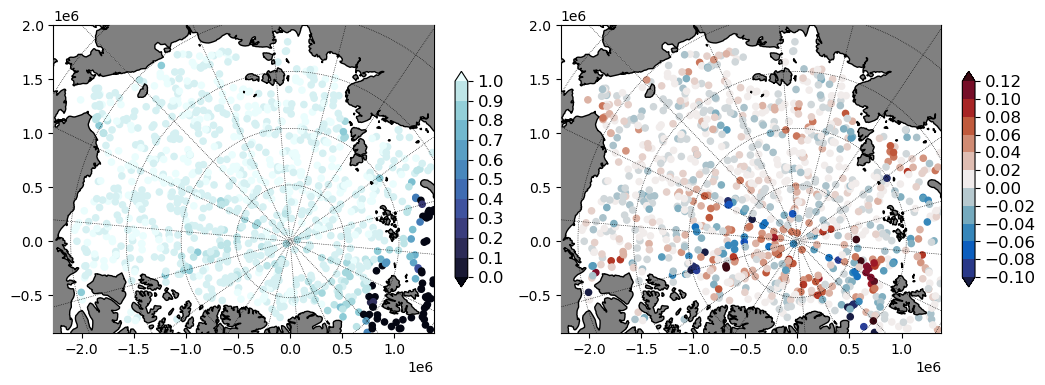

In [38]:
##plot obs network and innovations
##which obs variable to show?
vname = 'seaice_conc'
obs_rec_id = 0
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice
vmin_diff = -0.1
vmax_diff = 0.1
cmap_diff = cmocean.cm.balance

# obs sequence
seq = np.load(os.path.join(c.analysis_dir(c.time), f"obs_seq.rec{obs_rec_id}.npy"), allow_pickle=True).item()
# obs prior sequence for member
prior_seq = np.load(os.path.join(c.analysis_dir(c.time), f"obs_prior_seq.rec{obs_rec_id}.mem{mem_id:03}.npy"), allow_pickle=True)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot the obs seq
c.grid.plot_scatter(ax[0], seq['obs'], x=seq['x'], y=seq['y'], vmin=vmin, vmax=vmax, cmap=cmap, markersize=20)
add_colorbar(fig, ax[0], cmap, vmin, vmax)

# plot the innovations
c.grid.plot_scatter(ax[1], seq['obs']-prior_seq, x=seq['x'], y=seq['y'], vmin=vmin_diff, vmax=vmax_diff, cmap=cmap_diff, markersize=20)
add_colorbar(fig, ax[1], cmap_diff, vmin_diff, vmax_diff)

for i in range(2):
    c.grid.plot_land(ax[i], color='gray')


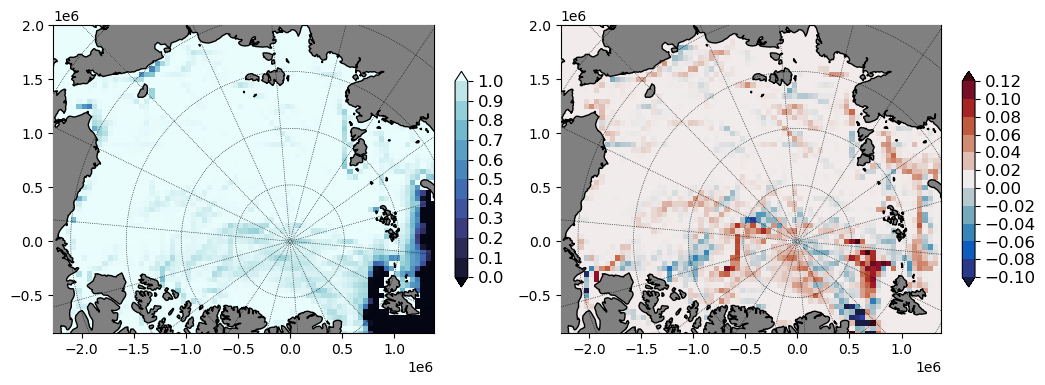

In [39]:
#plot analysis increment
c.time = datetime(2010, 1, 2, 6, tzinfo=timezone.utc)

##which state variable to show?
vname = 'seaice_conc_dg'
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice
vmin_diff = -0.1
vmax_diff = 0.1
cmap_diff = cmocean.cm.balance

# read from model restart files
path = c.forecast_dir(c.prev_time, 'nextsim.dg')
fld0 = model.read_var(path=path, member=mem_id, time=c.time, name=vname, k=k)
path = c.forecast_dir(c.time, 'nextsim.dg')
fld1 = model.read_var(path=path, member=mem_id, time=c.time, name=vname, k=k)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

c.grid.plot_field(ax[0], fld0[...], vmin, vmax, cmap=cmap)
add_colorbar(fig, ax[0], cmap, vmin, vmax)

c.grid.plot_field(ax[1], (fld1-fld0)[...], vmin_diff, vmax_diff, cmap=cmap_diff)
add_colorbar(fig, ax[1], cmap_diff, vmin_diff, vmax_diff)

for i in range(2):
    c.grid.plot_land(ax[i], color='gray')


### Diagnose error and ensemble spread

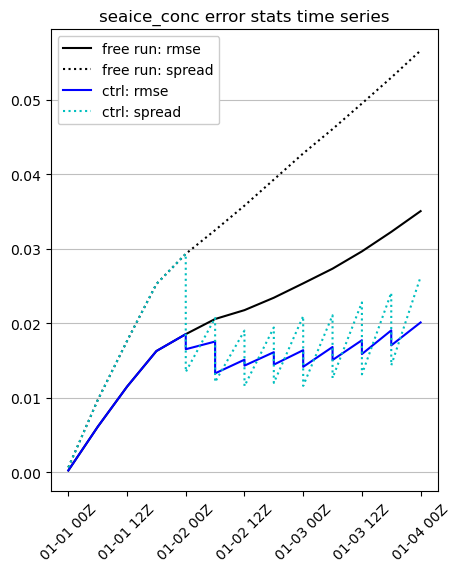

In [21]:
expt = 'ctrl'
vname = 'seaice_conc'

plt.figure(figsize=(5,6))

# free run
cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle-free"
ts, rmse_ts_free, sprd_ts_free = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts_free, 'k-', label='free run: rmse')
plt.plot(ts, sprd_ts_free, 'k:', label='free run: spread')

# from the case
cycle_dir = f"/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle-{expt}"
ts, rmse_ts, sprd_ts = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts, 'b-', label=f'{expt}: rmse')
plt.plot(ts, sprd_ts, 'c:', label=f'{expt}: spread')

# add annotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HZ'))
plt.grid(axis='y', color='gray', alpha=0.5)
plt.legend(framealpha=1.0)
plt.title(f"{vname} error stats time series")
_ = plt.xticks(rotation=45)

plt.savefig(os.path.join("plots", f"case_{expt}_{vname}.png"))


Comparison of a few example cases using different filter parameters:

- `ctrl`: control setting in `config-ctrl.yml`
- `large-roi`: localization radius of influence (roi) is increased 10x, causing ensemble spread collapsing too much.
- `adapt-inf`: increase roi and turning on adaptive inflation after assimilation.
- `etkf`: using a different EnKF variant, has different response to same roi.


In [34]:
# cases to be compared
expts = ['ctrl', 'large-roi', 'adapt-inf', 'etkf']

# show the error stats ts plots side by side
vname = 'seaice_conc'
html = '<div style="display: flex; gap: 10px;">'
for expt in expts:
    file = os.path.join("plots", f"case_{expt}_{vname}.png")
    html += f'<img src="{file}" style="max-height:400px;">'
html += '</div>'
display(HTML(html))

vname = 'seaice_thick'
html = '<div style="display: flex; gap: 10px;">'
for expt in expts:
    file = os.path.join("plots", f"case_{expt}_{vname}.png")
    html += f'<img src="{file}" style="max-height:400px;">'
html += '</div>'
display(HTML(html))